Random Forest ROC AUC mean: 0.9996648692280873
Logistic Regression ROC AUC mean: 0.8663082529178423


c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

XGBoost ROC AUC mean: 0.9991596480353246

--- Classification Report - Random Forest ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3523
           1       0.69      0.25      0.37        79

    accuracy                           0.98      3602
   macro avg       0.84      0.63      0.68      3602
weighted avg       0.98      0.98      0.98      3602



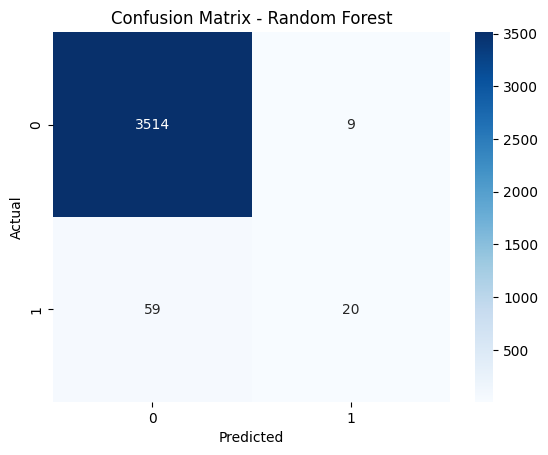

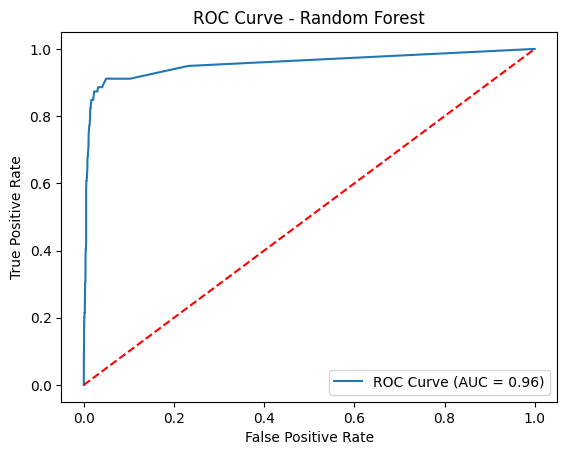


--- Classification Report - Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3523
           1       0.05      0.57      0.09        79

    accuracy                           0.75      3602
   macro avg       0.52      0.66      0.47      3602
weighted avg       0.97      0.75      0.84      3602



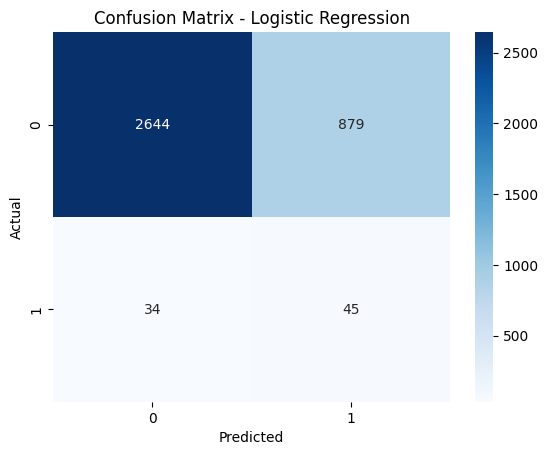

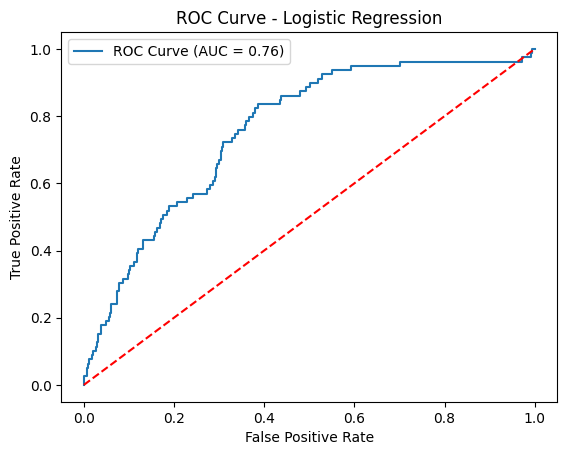


--- Classification Report - XGBoost ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3523
           1       0.43      0.23      0.30        79

    accuracy                           0.98      3602
   macro avg       0.71      0.61      0.64      3602
weighted avg       0.97      0.98      0.97      3602



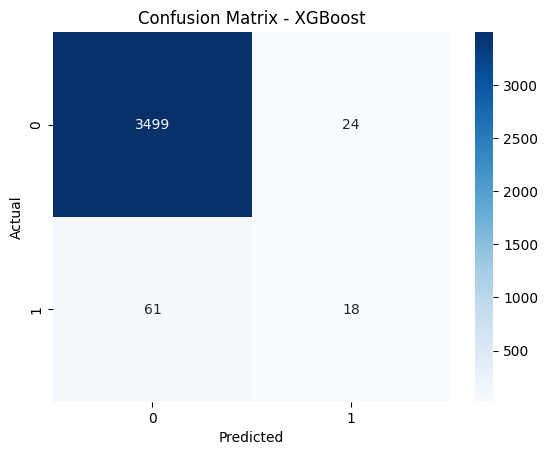

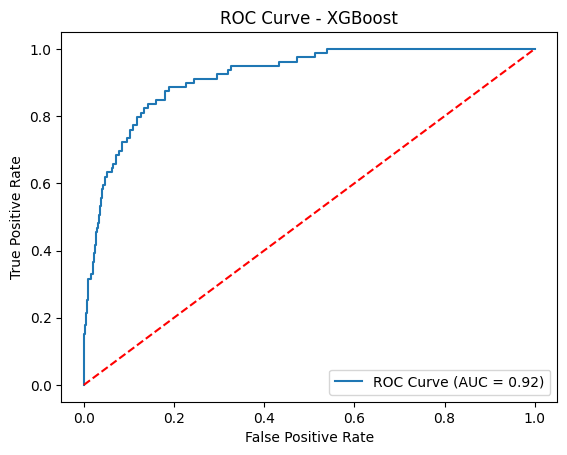

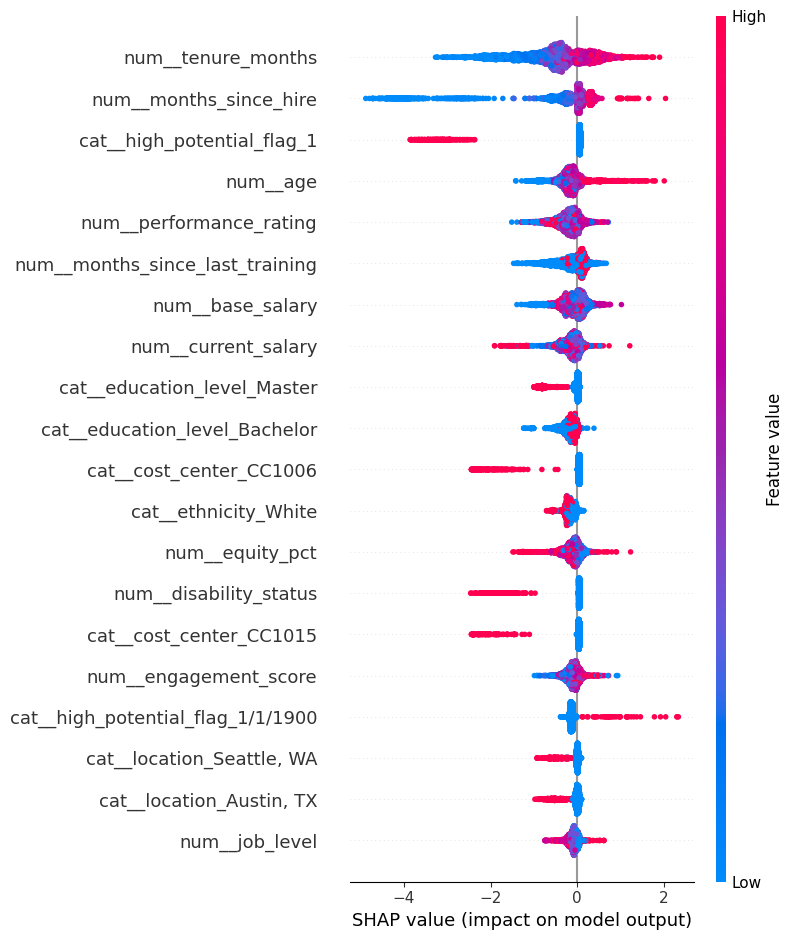


Export complete: 'main_for_tableau.csv' ready for Excel/Tableau.


In [ ]:
# Modeling.ipynb

# Imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import shap

# Load the data 
X_train = pd.read_csv('X_train_resampled.csv')
y_train = pd.read_csv('y_train_resampled.csv').squeeze()
X_test = pd.read_csv('X_test_transformed.csv')
y_test = pd.read_csv('y_test.csv').squeeze()

# The feature names are now the columns of the loaded DataFrames
feature_names = X_train.columns.tolist()

# ----- Random Forest Model -----
# The pipeline now only contains the classifier
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit directly on the preprocessed data
rf_pipeline.fit(X_train, y_train)
# Cross-validation here is validating the model on different folds of the SMOTE data.
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest ROC AUC mean:", rf_scores.mean())


# ----- Logistic Regression Model -----
logreg_pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression ROC AUC mean:", logreg_scores.mean())


# ----- XGBoost Model -----
xgb_pipeline = Pipeline(steps=[
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("XGBoost ROC AUC mean:", xgb_scores.mean())


# ----- Extract and save model insights -----
# The feature names are now simply the columns of the X_train DataFrame.

# Extract RF feature importances
rf_model = rf_pipeline.named_steps['classifier']
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
rf_feature_importance.to_csv('rf_feature_importance.csv', index=False)

# Extract Log Reg feature importances
logreg_model = logreg_pipeline.named_steps['classifier']
coefficients = logreg_model.coef_[0]
logreg_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)
logreg_coef_df.to_csv('logreg_coefficients.csv', index=False)

# Extract XGB feature importances
xgb_model = xgb_pipeline.named_steps['classifier']
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
xgb_feature_importance.to_csv('xgb_feature_importance.csv', index=False)


# ----- Evaluation on test set -----
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n--- Classification Report - {model_name} ---")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    return y_pred, y_proba

# Evaluate all models
rf_pred, rf_proba = evaluate_model(rf_pipeline, X_test, y_test, 'Random Forest')
logreg_pred, logreg_proba = evaluate_model(logreg_pipeline, X_test, y_test, 'Logistic Regression')
xgb_pred, xgb_proba = evaluate_model(xgb_pipeline, X_test, y_test, 'XGBoost')


# ----- SHAP explanations for XGBoost -----
# The input X_test is already the transformed data the model expects
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Convert X_test to a DataFrame for better plotting labels
X_test_shap_for_xgb = pd.DataFrame(X_test, columns=feature_names)
shap.summary_plot(shap_values_xgb, X_test_shap_for_xgb)

# ----- Export results -----
# Load the full original test data (saved from Preprocessing.ipynb)
final_output_df = pd.read_csv('original_test_set_full_data.csv')

# Ensure date columns are datetime for consistency
final_output_df['snapshot_date'] = pd.to_datetime(final_output_df['snapshot_date'])
# Ensure employee_id is string if that's what Tableau expects, or consistent type.
final_output_df['employee_id'] = final_output_df['employee_id'].astype(str)

# Add model predictions and probabilities
final_output_df['rf_prediction'] = rf_pred
final_output_df['rf_probability'] = rf_proba
final_output_df['logreg_prediction'] = logreg_pred
final_output_df['logreg_probability'] = logreg_proba
final_output_df['xgb_prediction'] = xgb_pred
final_output_df['xgb_probability'] = xgb_proba

# Rename future_terminated_flag to actual_terminated_flag for clarity in output
final_output_df.rename(columns={'future_terminated_flag': 'actual_terminated_flag'}, inplace=True)

# Save final clean business-friendly file
final_output_df.to_csv('main_for_tableau.csv', index=False)

print("\nExport complete: 'main_for_tableau.csv' ready for Excel/Tableau.")